# Install dependencies

In [10]:
# To avoid access problems to PyPI repository, execute these instructions directly 
# from the terminal, with the conda environment enabled

!pip install -r ../setup/requirements_ipynb.txt
!pip install -r ../setup/requirements.txt
!pip install -r ../setup/requirements_ml_model.txt
!pip install -r ../setup/requirements_prepro.txt

Looking in indexes: https://nexus.dataspartan.com/repository/pypi-all/simple, https://nexus.dataspartan.com/repository/pypi-snapshot/simple
Looking in indexes: https://nexus.dataspartan.com/repository/pypi-all/simple, https://nexus.dataspartan.com/repository/pypi-snapshot/simple
Looking in indexes: https://nexus.dataspartan.com/repository/pypi-all/simple, https://nexus.dataspartan.com/repository/pypi-snapshot/simple
Looking in indexes: https://nexus.dataspartan.com/repository/pypi-all/simple, https://nexus.dataspartan.com/repository/pypi-snapshot/simple
  Using cached https://nexus.dataspartan.com/repository/pypi-snapshot/packages/evoml-preprocessor/3.0.0rc6/evoml_preprocessor-3.0.0rc6-cp38-cp38-linux_x86_64.whl (28.4 MB)
  Using cached https://nexus.dataspartan.com/repository/pypi-snapshot/packages/evoml-api-models/3.0.1rc4/evoml_api_models-3.0.1rc4-cp38-cp38-linux_x86_64.whl (1.0 MB)
  Using cached https://nexus.dataspartan.com/repository/pypi-all/packages/idna/3.4/idna-3.4-py3-none-

# Imports

### Standard Imports

In [11]:
import sys
from pathlib import Path
from typing import Tuple, List, Dict
import json

import numpy as np
import pandas as pd

from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, precision_recall_curve, brier_score_loss, precision_score, recall_score, f1_score
)
from sklearn.utils import Bunch
import shap

from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import plot_partial_dependence
import scikitplot as skplt
import matplotlib.pyplot as plt
from rich.console import Console
from rich.style import Style
from rich.text import Text
from rich.table import Table

ROOT_DIR = Path("..")

In [24]:
!pip freeze > temp_req.txt

### Pipeline Imports
Local code available in this folder

In [12]:
sys.path.insert(0, str(ROOT_DIR / "src"))  # We're in $root/notebooks, code is in $root/src
from pipeline.pipeline_handler import PipelineHandler
from pipeline.conf.conf_manager import conf_mgr

# Load the Data
We're working with the `sample.csv` provided in the `data/` folder, but you can replace this with any dataframe following the correct schema.
For instance, you can download the original test data from the platform.

In [13]:
data_path = ROOT_DIR / "data" / "sample.csv"
data = pd.read_csv(data_path)  # Adapt to the filetype of your data
data

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2021-03-30,128.419998,129.752502,127.050003,128.717499,128.600464,20020400
1,2021-03-31,130.154999,134.705002,129.824997,133.482498,133.361130,31477600
2,2021-04-01,135.722504,138.699997,135.112503,138.117493,137.991913,30827600
3,2021-04-02,135.722504,138.699997,135.112503,138.117493,137.991913,0
4,2021-04-03,136.706670,139.179998,135.851669,138.703329,138.577215,0
5,2021-04-04,137.690837,139.659998,136.590836,139.289164,139.162516,0
6,2021-04-05,138.675003,140.139999,137.330002,139.875000,139.747818,25567200
7,2021-04-06,139.997498,140.542496,137.735001,138.615005,138.488968,19174400
8,2021-04-07,138.807495,142.434998,137.115005,141.434998,141.306396,25128400
9,2021-04-08,142.527496,144.714996,142.490005,143.169998,143.039825,24441600


# Load the pipeline Handler
The pipeline handler is the main access to the different components of the deliverable:
- `handler.preprocessor` for preprocessing
- `handler.model` for predicting

In [14]:
handler = PipelineHandler(conf_mgr.pipeline_data_conf)
label = handler.train_target
y_test = data[label]

# Preprocess the Data

In [15]:
preprocessed = handler.preprocessor.transform(data)

# it is integral to set this index 
test = preprocessed.set_index(preprocessed.columns[0]) 
test

,Date_unix_timestamp,Date_day_of_week,Date_day_of_year,Date_week_of_year,Date_is_weekend,Date_quarter,Date_relative_year,Date_month,Date_day,Open,High,Low,Adj_Close,Volume
Date,,,,,,,,,,,,,,
2021-03-30,1.000722,0.166667,0.241096,0.230769,0.0,0.000000,1.0,0.181818,0.966667,0.806058,0.802256,0.810365,0.798366,20020400
2021-03-31,1.001443,0.333333,0.243836,0.230769,0.0,0.000000,1.0,0.181818,1.000000,0.820506,0.843108,0.833805,0.837530,31477600
2021-04-01,1.002165,0.500000,0.246575,0.230769,0.0,0.333333,1.0,0.272727,0.000000,0.866868,0.876062,0.878469,0.875626,30827600
2021-04-02,1.002886,0.666667,0.249315,0.230769,0.0,0.333333,1.0,0.272727,0.033333,0.866868,0.876062,0.878469,0.875626,0
2021-04-03,1.003608,0.833333,0.252055,0.230769,1.0,0.333333,1.0,0.272727,0.066667,0.875063,0.880021,0.884712,0.880441,0
2021-04-04,1.004329,1.000000,0.254795,0.230769,0.0,0.333333,1.0,0.272727,0.100000,0.883259,0.883981,0.890956,0.885256,0
2021-04-05,1.005051,0.000000,0.257534,0.250000,0.0,0.333333,1.0,0.272727,0.133333,0.891454,0.887940,0.897200,0.890071,25567200
2021-04-06,1.005772,0.166667,0.260274,0.250000,0.0,0.333333,1.0,0.272727,0.166667,0.902467,0.891260,0.900621,0.879715,19174400
2021-04-07,1.006494,0.333333,0.263014,0.250000,0.0,0.333333,1.0,0.272727,0.200000,0.892557,0.906871,0.895384,0.902893,25128400


# Perform Prediction

In [16]:
y_pred = handler.model.predict(test)
y_pred

Date
2021-03-30    129.512691
2021-03-31    129.577162
2021-04-01    129.641632
2021-04-02    129.706103
2021-04-03    129.770573
2021-04-04    129.835044
2021-04-05    129.899514
2021-04-06    129.963985
2021-04-07    130.028455
2021-04-08    130.092926
2021-04-09    130.157397
Name: Close, dtype: float64

# Forecasting/Summary

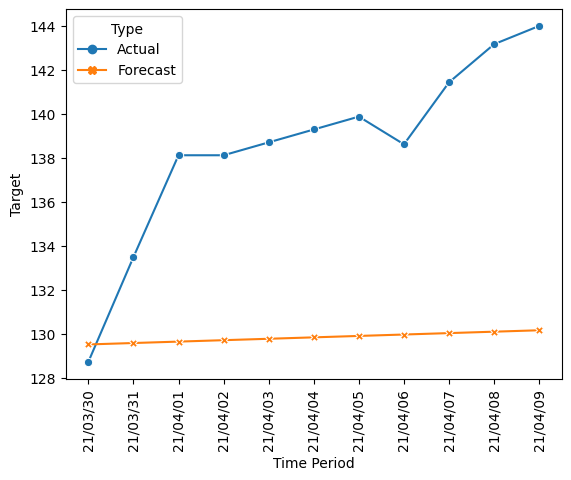

In [24]:
import seaborn as sns
import matplotlib.dates as mdates

# Assume these are your time periods and forecasts
time_periods = list(y_pred.index)
forecasted_data = list(y_pred.values)
actual_data = list(y_test)

# Create a DataFrame
data = pd.DataFrame({
    "Time Period": time_periods*2,
    "Target": actual_data + forecasted_data,
    "Type": ["Actual"] * len(actual_data)+ ["Forecast"] * len(forecasted_data)
})

# Plot the data
sns.lineplot(x="Time Period", y="Target", hue="Type", style="Type", markers=True, dashes=False, data=data)

# Get the current Axes object
ax = plt.gca()

# Format x-axis to display datetime correctly
date_format = mdates.DateFormatter('%y/%m/%d') # the format is according to your need
ax.xaxis.set_major_formatter(date_format)

# Rotate the x-axis labels so they display better
plt.xticks(time_periods, rotation='vertical')

plt.show()

# Forecasting/Residuals/Scatter

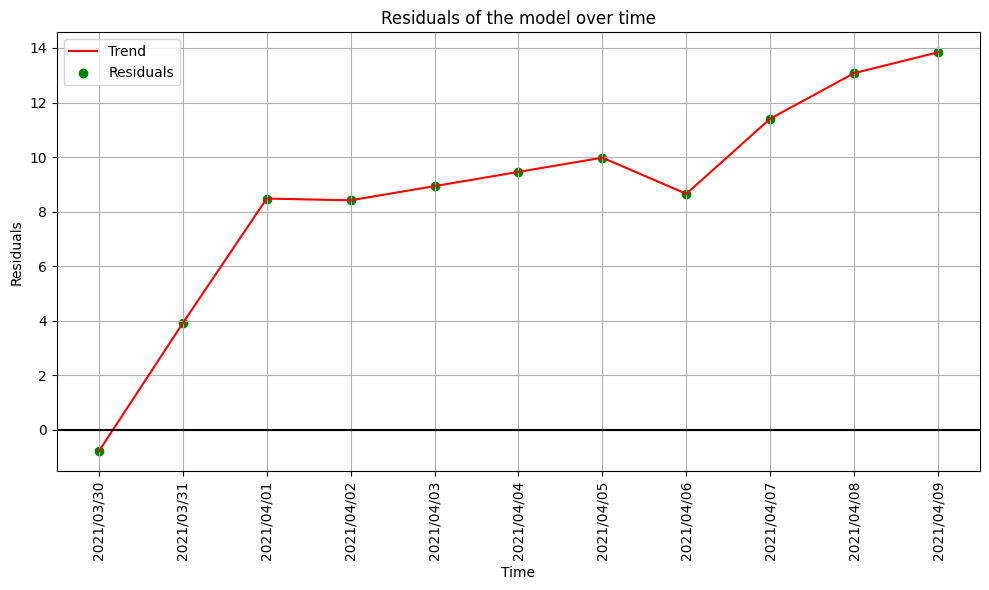

In [25]:
# Calculating residuals
residuals = y_test - list(y_pred.values)

plt.figure(figsize=(10,6))

# Scatter Plot
plt.scatter(y_pred.index, residuals, color='g', label='Residuals')

# Line Plot
plt.plot(y_pred.index, residuals, color='r', label='Trend')

plt.grid(True)
plt.axhline(0, color='black')

# Formatting date
date_format = mdates.DateFormatter('%Y/%m/%d')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(y_pred.index, rotation='vertical')

# Labels and title
plt.title('Residuals of the model over time')
plt.xlabel('Time')
plt.ylabel('Residuals')

# Add legend
plt.legend()

plt.tight_layout()
plt.show()